In [3]:
!pip install pycaret

,Description,Value
0,Session id,42
1,Target,is_hazardous
2,Target type,Binary
3,Original data shape,"(338199, 6)"
4,Transformed data shape,"(338199, 6)"
5,Transformed train set shape,"(236739, 6)"
6,Transformed test set shape,"(101460, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9134,0.9445,0.5316,0.7172,0.6105,0.5631,0.5711,5.9770
rf,Random Forest Classifier,0.9123,0.9434,0.5303,0.7096,0.6070,0.5588,0.5663,14.4690
lightgbm,Light Gradient Boosting Machine,0.8877,0.9042,0.2010,0.7128,0.3134,0.2726,0.3387,0.7050
gbc,Gradient Boosting Classifier,0.8853,0.8952,0.1583,0.7361,0.2604,0.2255,0.3062,15.7490
ada,Ada Boost Classifier,0.8835,0.8859,0.1581,0.6921,0.2571,0.2201,0.2929,3.7930
dt,Decision Tree Classifier,0.8824,0.7386,0.5456,0.5390,0.5422,0.4748,0.4748,0.4810
knn,K Neighbors Classifier,0.8779,0.8478,0.3809,0.5301,0.4433,0.3768,0.3833,0.7120
svm,SVM - Linear Kernel,0.8724,0.8115,0.0000,0.0000,0.0000,0.0000,0.0000,0.2030
qda,Quadratic Discriminant Analysis,0.8724,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1460
dummy,Dummy Classifier,0.8724,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1080


Best PyCaret Model: ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=42, verbose=0,
                     warm_start=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Transformation Pipeline and Model Successfully Saved


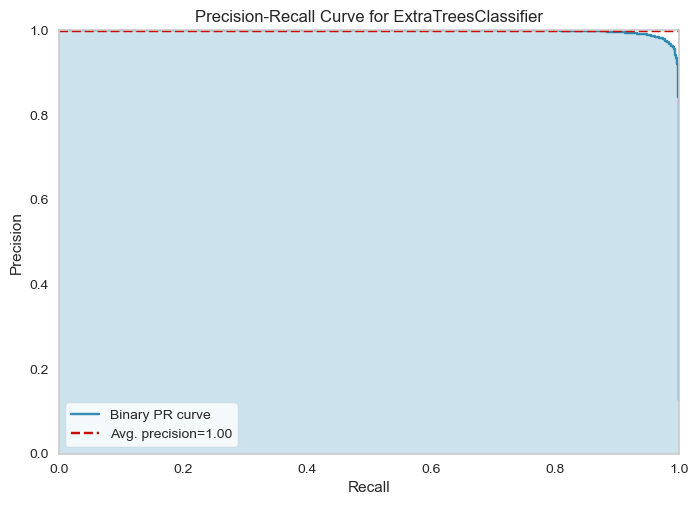

Best Scikit-learn Model: Random Forest
PR-AUC Score: 0.73

Model: Logistic Regression
PR-AUC Score: 0.35
Classification Report:
              precision    recall  f1-score       support
False          0.879560  0.988307  0.930768  59011.000000
True           0.482371  0.074516  0.129091   8629.000000
accuracy       0.871733  0.871733  0.871733      0.871733
macro avg      0.680965  0.531412  0.529929  67640.000000
weighted avg   0.828890  0.871733  0.828496  67640.000000
Confusion Matrix:
[[58321   690]
 [ 7986   643]]

Model: Decision Tree
PR-AUC Score: 0.60
Classification Report:
              precision    recall  f1-score       support
False          0.938451  0.935080  0.936763  59011.000000
True           0.566678  0.580600  0.573555   8629.000000
accuracy       0.889858  0.889858  0.889858      0.889858
macro avg      0.752565  0.757840  0.755159  67640.000000
weighted avg   0.891023  0.889858  0.890427  67640.000000
Confusion Matrix:
[[55180  3831]
 [ 3619  5010]]

Model: Random

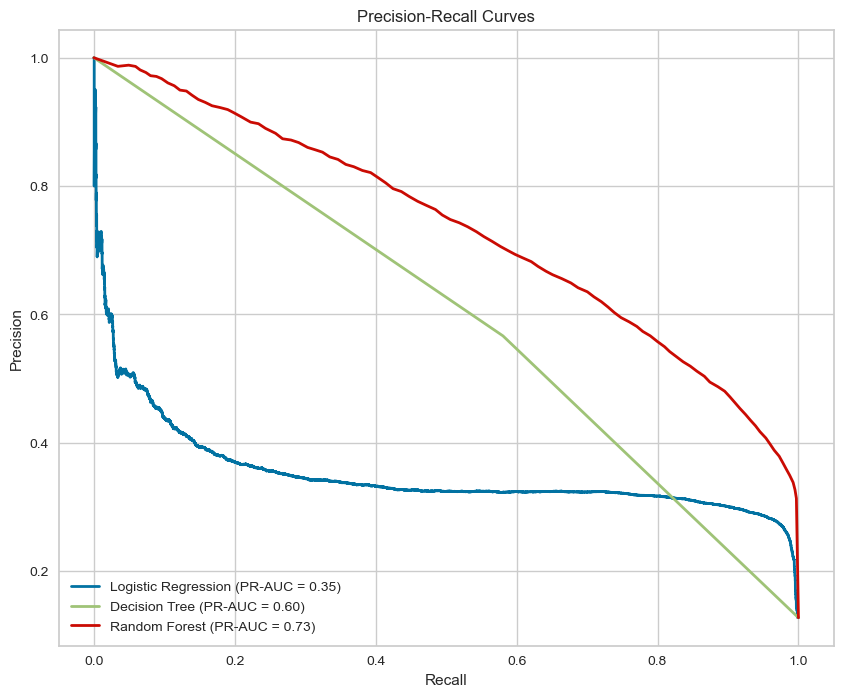

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from pycaret.classification import *

# Load the dataset
df = pd.read_csv('C:/Users/hp/OneDrive/Desktop/kdd/nearest-earth-objects(1910-2024).csv')

# Handle missing values separately for numeric and categorical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Impute missing values for numeric columns with median
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Impute missing values for categorical columns with the most frequent value
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

# Convert categorical features to numeric
df['orbiting_body'] = df['orbiting_body'].astype('category').cat.codes

# Feature Engineering: Calculate average diameter
df['estimated_diameter_avg'] = (df['estimated_diameter_min'] + df['estimated_diameter_max']) / 2

# Select features and target variable
features = ['absolute_magnitude', 'estimated_diameter_avg', 'relative_velocity', 'miss_distance', 'orbiting_body']
X = df[features]
y = df['is_hazardous']

# Combine features and target into a single DataFrame for PyCaret
data = X.copy()
data['is_hazardous'] = y

# Initialize the PyCaret environment
clf = setup(data, target='is_hazardous', session_id=42,
            normalize=True,  # Normalize features
            remove_multicollinearity=True,  # Remove multicollinearity
            ignore_features=None)  # Do not ignore any features

# Compare models using PyCaret
best_model_pycaret = compare_models()

# Print the best model in PyCaret
print(f"Best PyCaret Model: {best_model_pycaret}")

# Evaluate the best PyCaret model
evaluate_model(best_model_pycaret)

# Finalize and save the PyCaret model
final_model_pycaret = finalize_model(best_model_pycaret)
save_model(final_model_pycaret, 'best_neo_model_pycaret')

# Plot Precision-Recall curve for the best PyCaret model
plot_model(final_model_pycaret, plot='pr')

# --- Traditional scikit-learn Models ---
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Function to evaluate models
def evaluate_model_sklearn(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    report = classification_report(y_test, y_pred, output_dict=True)
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)
    
    confusion = confusion_matrix(y_test, y_pred)
    
    return report, pr_auc, confusion

# Evaluate all scikit-learn models
results = {}
for model_name, model in models.items():
    report, pr_auc, confusion = evaluate_model_sklearn(model, X_train_scaled, X_test_scaled, y_train, y_test)
    results[model_name] = {'report': report, 'pr_auc': pr_auc, 'confusion': confusion}

# Print the results for scikit-learn models
best_model_name = max(results, key=lambda x: results[x]['pr_auc'])
print(f"Best Scikit-learn Model: {best_model_name}")
print(f"PR-AUC Score: {results[best_model_name]['pr_auc']:.2f}")

# Display all model results
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    print(f"PR-AUC Score: {metrics['pr_auc']:.2f}")
    print("Classification Report:")
    print(pd.DataFrame(metrics['report']).transpose())
    print("Confusion Matrix:")
    print(metrics['confusion'])

# Plot Precision-Recall curves for all scikit-learn models
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, lw=2, label=f'{model_name} (PR-AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="lower left")
plt.show()